## Create Matrix X

In [1]:
import numpy as np
from numpy import random as rd
from numpy.linalg import det, inv
import pandas as pd

In [2]:
np.random.seed(12345676)
n = 10

In [57]:
A = np.zeros( (10 , 10 ))

In [58]:
for i in range(A.shape[0] -1 ):
    A[:, i] = np.random.normal(0, 1, 10)

In [60]:
A[:, 9] = A[:, 1] + A[:, 3]+ A[:, 2]

In [62]:
Q, R = np.linalg.qr( A , mode='reduced')

In [63]:
QI = np.matmul( Q.T, I )
x_qr = np.linalg.solve( R , QI )

In [ ]:
x_qr

In [ ]:
np.linalg.inv( A )

# 2. Analyzing RCT data with Precision Adjustment

In [38]:
import pandas as pd
import pyreadr
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
## loading the data
Penn = pd.read_csv("../data/penn_jae.dat" , sep='\s', engine='python')
n = Penn.shape[0]
p_1 = Penn.shape[1]
Penn = Penn[ (Penn['tg'] == 2) | (Penn['tg'] == 0) ]

c:\python\python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='inuidur1', ylabel='Density'>

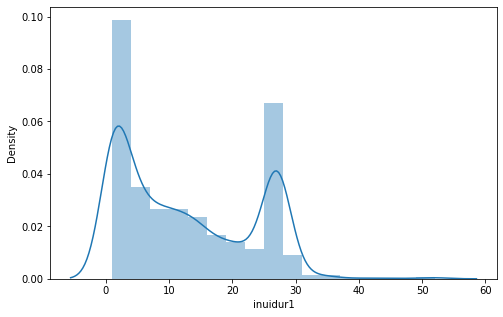

In [44]:
#Plotting the inuidur1 variable for the tg=2 group
fig, ax = plt.subplots(figsize=(8, 5))

sns.distplot(Penn[(Penn['tg'] == 2)].inuidur1)


c:\python\python38\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='inuidur1', ylabel='Density'>

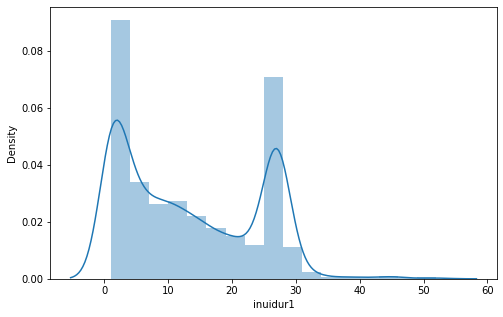

In [45]:
#Plotting the inuidur1 variable for the tg=0 group
fig, ax = plt.subplots(figsize=(8, 5))

sns.distplot(Penn[(Penn['tg'] == 0)].inuidur1)

We can see that the distributions of the control and the treatment group is similar, though the control group has more observations closer to the lower values of inuidur1.

In [ ]:
#this columns were not dropped out :  Unnamed: 13, recall
Penn.columns
Penn.info()

In [47]:
# Dependent variable
Penn['T2'] = (Penn[['tg']]==2).astype(int)

# Create category variable
Penn['dep'] = Penn['dep'].astype( 'category' )
Penn.head()

,abdt,tg,inuidur1,inuidur2,female,black,hispanic,othrace,dep,q1,...,q6,recall,agelt35,agegt54,durable,nondurable,lusd,husd,muld,T2
0,10824,0,18,18,0,0,0,0,2,0,...,0,0,0,0,0,0,1,0,NaN,0
1,10635,2,7,3,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,NaN,1
3,10824,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,NaN,0
4,10747,0,27,27,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,NaN,0
9,10754,2,20,20,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,NaN,1


In [48]:
Penn['dep'].unique()

[2, 0, 1]
Categories (3, int64): [2, 0, 1]

### Model 
To evaluate the impact of the treatments on unemployment duration, we consider the linear regression model:

$$
Y =  D \beta_1 + W'\beta_2 + \varepsilon, \quad E \varepsilon (D,W')' = 0,
$$

where $Y$ is  the  log of duration of unemployment, $D$ is a treatment  indicators,  and $W$ is a set of controls including age group dummies, gender, race, number of dependents, quarter of the experiment, location within the state, existence of recall expectations, and type of occupation.   Here $\beta_1$ is the ATE, if the RCT assumptions hold rigorously.


We also consider interactive regression model:

$$
Y =  D \alpha_1 + D W' \alpha_2 + W'\beta_2 + \varepsilon, \quad E \varepsilon (D,W', DW')' = 0,
$$
where $W$'s are demeaned (apart from the intercept), so that $\alpha_1$ is the ATE, if the RCT assumptions hold rigorously.

Under RCT, the projection coefficient $\beta_1$ has
the interpretation of the causal effect of the treatment on
the average outcome. We thus refer to $\beta_1$ as the average
treatment effect (ATE). Note that the covariates, here are
independent of the treatment $D$, so we can identify $\beta_1$ by
just linear regression of $Y$ on $D$, without adding covariates.
However we do add covariates in an effort to improve the
precision of our estimates of the average treatment effect.

### Analysis

We consider 

*  classical 2-sample approach, no adjustment (CL)
*  classical linear regression adjustment (CRA)
*  interactive regression adjusment (IRA)


# Carry out covariate balance check

In [50]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import numpy as np

## Regress  on all covariates


In [66]:
y = Penn[['T2']].reset_index( drop = True )

In [67]:
# Get data from R
result = pyreadr.read_r('../data/m_reg_g1.RData')
X_vars = result['X1']

In [74]:
model_results = sm.OLS( y , X_vars ).fit().get_robustcov_results(cov_type = "HC1")

print(model_results.summary())
print( "Number of regressors in the basic model:",len(model_results.params), '\n')

                            OLS Regression Results                            
Dep. Variable:                     T2   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                     4.204
Date:                Sun, 10 Oct 2021   Prob (F-statistic):           2.42e-39
Time:                        15:02:13   Log-Likelihood:                -4075.6
No. Observations:                5782   AIC:                             8357.
Df Residuals:                    5679   BIC:                             9043.
Df Model:                         102                                         
Covariance Type:                  HC1                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
(Intercept)              0.5171 

c:\python\python38\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 102, but rank is 101
  warnings.warn('covariance of constraints does not have full '


We see that that even though this is a randomized experiment, balance conditions are failed.

# Model Specification
I use data from R.

## 1.  (CL)

In [75]:
# model specifications
# take log of inuidur1
Penn["log_inuidur1"] = np.log( Penn["inuidur1"] ) 
log_inuidur1 = pd.DataFrame(np.log( Penn["inuidur1"] ) ).reset_index( drop = True )

# no adjustment (2-sample approach)
formula_cl = 'log_inuidur1 ~ T2'

# adding controls
# Omitted dummies: q1, nondurable, muld

ols_cl = smf.ols( formula = formula_cl, data = Penn ).fit().get_robustcov_results(cov_type = "HC1")




# Results 
print(ols_cl.summary())


                            OLS Regression Results                            
Dep. Variable:           log_inuidur1   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     5.879
Date:                Sun, 10 Oct 2021   Prob (F-statistic):             0.0154
Time:                        15:02:51   Log-Likelihood:                -9344.7
No. Observations:                5782   AIC:                         1.869e+04
Df Residuals:                    5780   BIC:                         1.871e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0568      0.021     98.158      0.0

## 2. CRA

In [76]:
#getting data
# Get data from R
result = pyreadr.read_r('../data/ols_cra_reg_sol.RData')
X_vars_cra = result['X1']

In [78]:
formula_cra = 'log_inuidur1 ~ T2 + (female+black+othrace+dep+q2+q3+q4+q5+q6+agelt35+agegt54+durable+lusd+husd)**2'

ols_cra = sm.OLS( log_inuidur1, X_vars_cra ).fit().get_robustcov_results(cov_type = "HC1")
print(ols_cra.summary())

                            OLS Regression Results                            
Dep. Variable:               inuidur1   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     84.52
Date:                Sun, 10 Oct 2021   Prob (F-statistic):               0.00
Time:                        15:06:44   Log-Likelihood:                -9180.6
No. Observations:                5782   AIC:                         1.857e+04
Df Residuals:                    5678   BIC:                         1.926e+04
Df Model:                         103                                         
Covariance Type:                  HC1                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
(Intercept)              2.4472 

c:\python\python38\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 103, but rank is 102
  warnings.warn('covariance of constraints does not have full '


## 3. Interactive regression adjustment (IRA)

In [79]:
# create Y variable 
log_inuidur1 = pd.DataFrame(np.log( Penn["inuidur1"] )).reset_index( drop = True )

# Reset index to estimation
# Get data from R

formula_ira = 'T2 ~ (female+black+othrace+dep+q2+q3+q4+q5+q6+agelt35+agegt54+durable+lusd+husd)**2'

result = pyreadr.read_r('../data/ols_ira_reg_g1.RData')
X_vars_ols_ira = result['S1']

ols_ira = sm.OLS(log_inuidur1, X_vars_ols_ira  ).fit().get_robustcov_results(cov_type = "HC1")

# Results 
print(ols_ira.summary())

                            OLS Regression Results                            
Dep. Variable:               inuidur1   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     35.02
Date:                Sun, 10 Oct 2021   Prob (F-statistic):               0.00
Time:                        15:07:31   Log-Likelihood:                -9129.1
No. Observations:                5782   AIC:                         1.866e+04
Df Residuals:                    5579   BIC:                         2.002e+04
Df Model:                         202                                         
Covariance Type:                  HC1                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
(Intercept)     

c:\python\python38\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 202, but rank is 188
  warnings.warn('covariance of constraints does not have full '


## 4. Interactive regression adjustment (IRA) using Lasso.

In [29]:
pip install multiprocess 

Note: you may need to restart the kernel to use updated packages.


In [30]:
import multiprocess

In [80]:
import hdmpy

Next we try out partialling out with lasso

In [81]:
# Get data from R
result = pyreadr.read_r('../data/rlasso_ira_reg_sol.RData')
X_vars = result['S']

In [83]:
result = hdmpy.rlassoEffects( X_vars, log_inuidur1, index = 0 )    

# we uploaded the hdmpy file but didn't book (method 2)

In [88]:
X_vars

,T2,Xfemale,Xblack,Xothrace,Xfactor(dep)1,Xfactor(dep)2,Xq2,Xq3,Xq4,Xq5,...,T2:Xagelt35:agegt54,T2:Xagelt35:durable,T2:Xagelt35:lusd,T2:Xagelt35:husd,T2:Xagegt54:durable,T2:Xagegt54:lusd,T2:Xagegt54:husd,T2:Xdurable:lusd,T2:Xdurable:husd,T2:Xlusd:husd
0,-0.419924,-0.400726,-0.118817,-0.005189,-0.116569,0.839329,-0.200104,-0.235559,-0.223279,0.736769,...,-0.0,0.030866,0.055632,0.051201,0.007916,0.013654,0.011620,0.023095,0.012201,-0.0
1,0.580076,-0.400726,-0.118817,-0.005189,-0.116569,-0.160671,-0.200104,0.764441,-0.223279,-0.263231,...,0.0,-0.042638,0.503228,-0.070729,-0.010935,-0.018861,-0.016052,-0.031903,-0.016855,0.0
2,-0.419924,-0.400726,-0.118817,-0.005189,-0.116569,-0.160671,-0.200104,-0.235559,-0.223279,0.736769,...,-0.0,0.030866,0.055632,0.051201,0.007916,0.013654,0.011620,0.023095,0.012201,-0.0
3,-0.419924,-0.400726,-0.118817,-0.005189,-0.116569,-0.160671,-0.200104,-0.235559,0.776721,-0.263231,...,-0.0,0.030866,0.055632,0.051201,0.007916,0.013654,0.011620,0.023095,0.012201,-0.0
4,0.580076,0.599274,-0.118817,-0.005189,-0.116569,-0.160671,-0.200104,-0.235559,0.776721,-0.263231,...,0.0,-0.042638,-0.076849,-0.070729,-0.010935,-0.018861,-0.016052,-0.031903,-0.016855,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5777,-0.419924,0.599274,-0.118817,0.994811,-0.116569,0.839329,-0.200104,-0.235559,-0.223279,0.736769,...,-0.0,0.030866,0.055632,0.051201,0.007916,0.013654,0.011620,0.023095,0.012201,-0.0
5778,0.580076,-0.400726,0.881183,-0.005189,-0.116569,-0.160671,-0.200104,-0.235559,0.776721,-0.263231,...,0.0,-0.042638,-0.076849,-0.070729,-0.010935,-0.018861,-0.016052,-0.031903,-0.016855,0.0
5779,-0.419924,-0.400726,-0.118817,-0.005189,-0.116569,0.839329,0.799896,-0.235559,-0.223279,-0.263231,...,-0.0,0.030866,-0.364292,0.051201,0.007916,0.013654,0.011620,0.023095,0.012201,-0.0
5780,0.580076,0.599274,-0.118817,-0.005189,-0.116569,-0.160671,-0.200104,-0.235559,0.776721,-0.263231,...,0.0,-0.042638,-0.076849,-0.070729,-0.010935,0.561215,-0.016052,-0.031903,-0.016855,0.0


In [87]:
result.res['coefficients']

,0
T2,-0.074573


In [89]:
rlasso_ira = pd.DataFrame(np.array( (result.res['coefficients'][0] , result.res['se'][0] , \
           result.res['t'][0] , result.res['pval'][0] ) ).reshape(1, 4) , columns = ['Coef.' , \
                            "Std.Err." , "t" , 'P>|t|'] , index = ['T2'])
rlasso_ira

,Coef.,Std.Err.,t,P>|t|
T2,-0.074573,0.032104,-2.322841,0.020188


### Results

In [90]:
table2 = np.zeros((2, 4))
table2[0,0] = ols_cl.summary2().tables[1]['Coef.']['T2']
table2[0,1] = ols_cra.summary2().tables[1]['Coef.']['T2TRUE']
table2[0,2] = ols_ira.summary2().tables[1]['Coef.']['T2TRUE']
table2[0,3] = rlasso_ira['Coef.']['T2']

table2[1,0] = ols_cl.summary2().tables[1]['Std.Err.']['T2']
table2[1,1] = ols_cra.summary2().tables[1]['Std.Err.']['T2TRUE']
table2[1,2] = ols_ira.summary2().tables[1]['Std.Err.']['T2TRUE']
table2[1,3] = rlasso_ira['Std.Err.']['T2']

table2 = pd.DataFrame(table2, columns = ["$CL$", "$CRA$", "$IRA$", "$IRA Lasso$"], \
                      index = ["estimate","standard error"])
table2
table2.to_latex
print(table2.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &      \$CL\$ &     \$CRA\$ &     \$IRA\$ &  \$IRA Lasso\$ \\
\midrule
estimate       & -0.078825 & -0.071207 & -0.069904 &    -0.074573 \\
standard error &  0.032509 &  0.032044 &  0.032076 &     0.032104 \\
\bottomrule
\end{tabular}



# Plotting

Using the 3. interactive regression adjustment (IRA) plot the coefficients of the next variables
- T2*female
- T2*black
- T2*agelt35
- T2*factor(dep)1

In [91]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt


In [92]:
result = pyreadr.read_r('../data/ols_ira_reg_g1.RData')
X_vars_ols_ira = result['S1']

ols_ira = sm.OLS(log_inuidur1, X_vars_ols_ira  ).fit().get_robustcov_results(cov_type = "HC1")

# Results 
print(ols_ira.summary())


sns.set(style="ticks") 
mpl.rc("figure", figsize=(10, 15))
    
sns.coefplot();

c:\python\python38\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 202, but rank is 188
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:               inuidur1   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     35.02
Date:                Sun, 10 Oct 2021   Prob (F-statistic):               0.00
Time:                        15:32:39   Log-Likelihood:                -9129.1
No. Observations:                5782   AIC:                         1.866e+04
Df Residuals:                    5579   BIC:                         2.002e+04
Df Model:                         202                                         
Covariance Type:                  HC1                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
(Intercept)     

AttributeError: module 'seaborn' has no attribute 'coefplot'

In [93]:
table3 = np.zeros((4, 2))

table3[0,0] = ols_ira.summary2().tables[1]['Coef.']['Xq2']
table3[1,0] = ols_ira.summary2().tables[1]['Coef.']['T2TRUE:Xblack']
table3[2,0] = ols_ira.summary2().tables[1]['Coef.']['T2TRUE:Xagelt35']
table3[3,0] = ols_ira.summary2().tables[1]['Coef.']['T2TRUE:Xfactor(dep)1']

table3[0,1] = ols_ira.summary2().tables[1]['Std.Err.']['T2TRUE:Xfemale']
table3[1,1] = ols_ira.summary2().tables[1]['Std.Err.']['T2TRUE:Xblack']
table3[2,1] = ols_ira.summary2().tables[1]['Std.Err.']['T2TRUE:Xagelt35']
table3[3,1] = ols_ira.summary2().tables[1]['Std.Err.']['T2TRUE:Xfactor(dep)1']




table3 = pd.DataFrame(table3, columns = ["coef",'err'], \
                      index = ['T2TRUE:Xfemale','T2TRUE:Xblack','T2TRUE:Xagelt35','T2TRUE:Xfactor(dep)1'])


In [94]:
table3 =table3.reset_index()
table3

,index,coef,err
0,T2TRUE:Xfemale,-0.254644,0.549897
1,T2TRUE:Xblack,0.452557,0.510319
2,T2TRUE:Xagelt35,1.123320,0.637419
3,T2TRUE:Xfactor(dep)1,0.763602,0.785448


<ipython-input-95-f3b38bcc47db>:7: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  ax.scatter(x=pd.np.arange(table3.shape[0]),


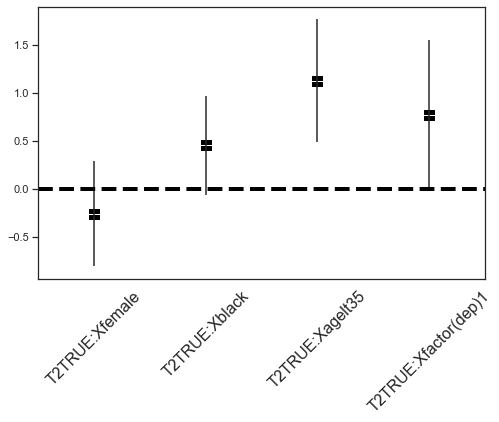

In [95]:
fig, ax = plt.subplots(figsize=(8, 5))
table3.plot(x='index', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr='err', legend=False)
ax.set_ylabel('')
ax.set_xlabel('')
ax.scatter(x=pd.np.arange(table3.shape[0]), 
           marker='s', s=120, 
           y=table3['coef'], color='black')
ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
ax.xaxis.set_ticks_position('none')
_ = ax.set_xticklabels(['T2TRUE:Xfemale','T2TRUE:Xblack','T2TRUE:Xagelt35','T2TRUE:Xfactor(dep)1'], 
                       rotation=45, fontsize=16)